In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sklearn
import joblib
import time

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, plot_roc_curve, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
import lightgbm as lgb

# Load the previous preprocessed and feature-engineered dataset

We already saved the previous state, so just load it again

> Disclaimer: You don't have to follow the coding style, you can use your own style. 

In [3]:
x_train_vect_id = joblib.load('../output/x_train_vect.pkl')
x_valid_vect_id = joblib.load('../output/x_valid_vect.pkl')
y_train_id = joblib.load('../output/y_train.pkl')
y_valid_id = joblib.load('../output/y_valid.pkl')

Oh, and also don't forget to drop the `id` column. We don't need that for modeling purpose.

In [4]:
x_train_vect = x_train_vect_id.drop(columns='id')
y_train = y_train_id.drop(columns='id')
x_valid_vect = x_valid_vect_id.drop(columns='id')
y_valid = y_valid_id.drop(columns='id')

# Try a single model

Now, let's see the performance of a single model. We'll use a Random Forest Classifier for our first experiment

In [5]:
# Initiate the model
rf = RandomForestClassifier(n_estimators = 50, random_state = 0, n_jobs=-1, verbose=1)

In [6]:
# Fit fit fit
rf.fit(x_train_vect, y_train.values.ravel())

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   32.6s finished


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=0, verbose=1)

In [7]:
# Predict the result and the probability
pred_res = rf.predict(x_valid_vect)
proba_res = rf.predict_proba(x_valid_vect)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


Now, let's see how's the F1 score

In [8]:
print(classification_report(y_valid, pred_res))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     39940
           1       0.78      0.33      0.46      4191

    accuracy                           0.93     44131
   macro avg       0.86      0.66      0.71     44131
weighted avg       0.92      0.93      0.91     44131



Whoa! We have a very low recall on the toxic class. 
* Means, only a few of the validation data (in class 1) that are correctly identified from all of the given examples

Why?
* Might because of imbalanced dataset
* Or wrong choice of classifier algorithm(?)
* Or wrong choice of parameters(?)
* Uncalibrated model(?)
* By default, the probability threshold is 0.5. But it can be adjusted.

In [9]:
print(f"Validation AUC : {roc_auc_score(y_valid, proba_res[:, 1])}")

Validation AUC : 0.8417329256829649


Oooh, look at the AUC, it's pretty good! Which means, the model could distinguish between positive and negative classes. So, we might need to find the best threshold. 

> p.s: Don't worry if you don't understand the F1 and AUC, we'll have some refreshment in the slide.

# The Better Way of Modeling

Now, we want to address those problems.

> note: Due to time limitation, we can't explain each solution in a dedicated chapter/sub-chapter. So there'll be some concepts that introduced simultaneously. 

First, let's define the model and set of hyperparams that we want to optimize. In this case, we'll use:
* Logistic Regression
* Random Forest
* Gradient Boosting using LGBM

> Note: The following coding style might not be the most efficient, but it does the job. Remember, at first iteration, only focus on your code is working.

In [10]:
def model_logreg(class_weight = None):
    """
    Function for initiating Logistic Regression Model
    """
    param_dist = {'C' : [0.25, 0.5, 1]}
    base_model = LogisticRegression(random_state=42, solver='liblinear', class_weight=class_weight)
    
    return param_dist, base_model

def model_rf(class_weight = None):
    """
    Function for initiating Random Forest Model
    """
    param_dist = {'n_estimators' : [25, 50, 100]}
    base_model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=class_weight)
    
    return param_dist, base_model

def model_lgb(class_weight = None):
    """
    Function for initiating LightGBM Model
    """
    param_dist = {'n_estimators' : [25, 50, 100], 'boosting_type':['gbdt', 'goss']}
    base_model = lgb.LGBMClassifier(random_state=42, n_jobs=-1, class_weight=class_weight)
    
    return param_dist, base_model

# Note, you can use as many as param dist, but in this session we'll only try few of them to save time.

Now, we want to create a function that do the hyperparameter optimization

In [11]:
def random_search_cv(model, param, scoring, n_iter, x, y, verbosity=0):
    """
    Just a function to run the hyperparameter search
    """
    random_fit = RandomizedSearchCV(estimator = model, 
                                    param_distributions = param, 
                                    scoring = scoring, 
                                    n_iter = n_iter, 
                                    cv = 5, 
                                    random_state = 42, 
                                    verbose = verbosity)
    random_fit.fit(x, y)
    return random_fit

Why do we use random search instead of grid search? [see here](https://stats.stackexchange.com/questions/160479/practical-hyperparameter-optimization-random-vs-grid-search)

## Probability Calibration

Are we there yet? Hold a sec, we'll introduce to you The **Probability Calibration**.
Now, let's move to [this link](https://scikit-learn.org/stable/modules/calibration.html) for a moment. 

Now, let's see the code

In [12]:
def calibrate_classifier(model, x_valid, y_valid):
    model_calibrated = CalibratedClassifierCV(model, cv='prefit')
    model_calibrated.fit(x_valid, y_valid)
    
    return model_calibrated

Now, this is our first time since the beginning to introduce the validation dataset. Why?

The calibration data and the training data should be disjoint, as stated in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html#sklearn.calibration.CalibratedClassifierCV)

Actually there are [2 ways](https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv) to ensure that the data is disjoint. But we'll use the first one. Anyway if you are really curious about why the data should be disjoint, you can read this [reference](https://www.chengli.io/publications/li2019learning.pdf). It stated that the data should be disjoint to avoid over-confident score when the model overfits. 

## Threshold Adjustment

In Scikit-learn, the default threshold is 0.5. But actually, moving the threshold sometimes could improve our model performance. Now, we want to decide which threshold is the best after we calibrate our models.

In [13]:
def tune_threshold(model, x_valid, y_valid, scorer):
    """
    Function for threshold adjustment
    
    Args:
        - model(callable): Sklearn model
        - x_valid(DataFrame):
        - y_valid(DataFrame):
        - scorer(callable): Sklearn scorer function, for example: f1_score
    """
    thresholds = np.linspace(0,1,101)
    proba = model.predict_proba(x_valid)[:, 1]
    proba = pd.DataFrame(proba)
    proba.columns = ['probability']
    score = []
    for threshold_value in thresholds:
        proba['prediction'] = np.where( proba['probability'] > threshold_value, 1, 0)
        metric_score = scorer(proba['prediction'], y_valid, average='macro')
        score.append(metric_score)
    metric_score = pd.DataFrame([thresholds,score]).T
    metric_score.columns = ['threshold','metric_score']
    best_score = (metric_score['metric_score'] == metric_score['metric_score'].max())
    best_threshold = metric_score[best_score]['threshold']
    
    return metric_score["metric_score"].max(), best_threshold.values[0]

In [14]:
def select_model(train_log_dict):
    max_score = max(train_log_dict['model_score'])
    max_index = train_log_dict['model_score'].index(max_score)
    best_model = train_log_dict['model_fit'][max_index]
    best_report = train_log_dict['model_report'][max_index]
    best_threshold = train_log_dict['threshold'][max_index]
    name = train_log_dict['model_name'][max_index]

    return best_model, best_report, best_threshold, name

In [15]:
def classif_report(model_obj, x_test, y_test, best_threshold=None, calc_auc=True):
    code2rel = {'0': 'Non-Toxic', '1': 'Toxic'}
    
    if best_threshold is None:
        pred = model_obj.predict(x_test)
    else:
        proba = model_obj.predict_proba(x_test)[:, 1]
        pred = np.where(proba > best_threshold, 1, 0)

    res = classification_report(
        y_test, pred, output_dict=True, zero_division=0)
    res = pd.DataFrame(res).rename(columns=code2rel).T

    if calc_auc:
        proba = model_obj.predict_proba(x_test)[:, 1]
        auc_score = roc_auc_score(y_test, proba)

        print(
            f"AUC score: {auc_score}, F1-Macro: {res['f1-score']['macro avg']}")
    return pred, res

# Let's put them together

First, We want to create a `fit` function as a wrapper 

In [16]:
def fit(x_train, y_train, model, model_param, scoring='f1', n_iter=3, verbosity=3):
    """
    Fit model
    
    Args:
        - model(callable): sklearn model
        - model_param(dict): sklearn's RandomizedSearchCV params_distribution
    
    Return:
        - model_fitted(callable): model with optimum hyperparams
    """
    model_fitted = random_search_cv(model, model_param, 
                                    scoring, 
                                    n_iter, 
                                    x_train, y_train, 
                                    verbosity)
    print(
        f'Model: {model_fitted.best_estimator_}, {scoring}: {model_fitted.best_score_}')
    
    return model_fitted

Then, we might create a validation wrapper that includes the calibration and threshold adjustment process as well as the final validation score for our model selection process.

In [17]:
def validate(x_valid, y_valid, model_fitted, tune = True):
    """
    Validate model

    Args:
        - x_valid(DataFrame): Validation independent variables
        - y_valid(DataFrame): Validation Dependent variables
        - model_fitted(callable): Sklearn / imblearn fitted model
    """
    code2rel = {'0': 'Non-Toxic', '1': 'Toxic'}

    # Calibrate Classifier
    model_calibrated = CalibratedClassifierCV(base_estimator=model_fitted,
                                              cv="prefit")
    model_calibrated.fit(x_valid, y_valid)
    
    if tune:
        metric_score, best_threshold = tune_threshold(model_calibrated,
                                                      x_valid,
                                                      y_valid,
                                                      f1_score)
        
        print(f'Best threshold is: {best_threshold}, with score: {metric_score}')
        pred_model, report_model = classif_report(model_calibrated,
                                                  x_valid,
                                                  y_valid,
                                                  best_threshold,
                                                  True)
    else:
        # Report default
        best_threshold = None
        pred_model, report_model = classif_report(
            model_calibrated, x_valid, y_valid, True)

    return report_model, model_calibrated, best_threshold



## Now, we'll define the main function

In [19]:
def main(x_train, y_train, x_valid, y_valid):
    
    # Add class weight
    class_weight = compute_class_weight(class_weight = 'balanced', 
                                        classes = np.unique(y_train), 
                                        y = y_train)
    class_weights = dict(zip(np.unique(y_train), class_weight))
    
    # Initiate models
    logreg = model_logreg
    rf = model_rf
    lgb = model_lgb
    
    # Initiate logs
    train_log_dict = {'model': [logreg, rf, lgb],
                      'model_name': [],
                      'model_fit': [],
                      'model_report': [],
                      'model_score': [],
                      'threshold': [],
                      'fit_time': []}


    # Try Each models
    for model in train_log_dict['model']:
        param_model, base_model = model(class_weights)
        train_log_dict['model_name'].append(base_model.__class__.__name__)
        print(f'Fitting {base_model.__class__.__name__}')

        # Train
        t0 = time.time()
        scoring = make_scorer(f1_score,average='macro')
        fitted_model = fit(
            x_train, y_train, base_model, param_model, scoring=scoring)
        elapsed_time = time.time() - t0
        print(f'elapsed time: {elapsed_time} s \n')
        train_log_dict['fit_time'].append(elapsed_time)

        # Validate
        report, calibrated_model, best_threshold = validate(
            x_valid, y_valid, fitted_model)
        train_log_dict['model_fit'].append(calibrated_model)
        train_log_dict['threshold'].append(best_threshold)
        train_log_dict['model_report'].append(report)
        train_log_dict['model_score'].append(report['f1-score']['macro avg'])

    best_model, best_report, best_threshold, name = select_model(
        train_log_dict)
    print(
        f"Model: {name}, Score: {best_report['f1-score']['macro avg']}")
    joblib.dump(best_model, '../output/mantab_model.pkl')
    joblib.dump(best_threshold, '../output/threshold.pkl')
    joblib.dump(train_log_dict, '../output/train_log.pkl')
    print(f'\n {best_report}')
    
    return best_model


Now, let's try running the code

In [20]:
best_model = main(x_train_vect, y_train.values.ravel(), x_valid_vect, y_valid.values.ravel())

Fitting LogisticRegression
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ............................C=0.25;, score=0.640 total time=   0.8s
[CV 2/5] END ............................C=0.25;, score=0.647 total time=   0.7s
[CV 3/5] END ............................C=0.25;, score=0.639 total time=   0.7s
[CV 4/5] END ............................C=0.25;, score=0.642 total time=   0.7s
[CV 5/5] END ............................C=0.25;, score=0.642 total time=   0.7s
[CV 1/5] END .............................C=0.5;, score=0.638 total time=   0.7s
[CV 2/5] END .............................C=0.5;, score=0.646 total time=   0.7s
[CV 3/5] END .............................C=0.5;, score=0.638 total time=   0.7s
[CV 4/5] END .............................C=0.5;, score=0.641 total time=   0.7s
[CV 5/5] END .............................C=0.5;, score=0.640 total time=   0.7s
[CV 1/5] END ...............................C=1;, score=0.637 total time=   0.7s
[CV 2/5] END .........

### ROC Curve

In [5]:
best_model = joblib.load('../output/mantab_model.pkl')
best_threshold = joblib.load('../output/threshold.pkl')

c:\users\ghifa\documents\pacmann\simple-ml-project-example\projectenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


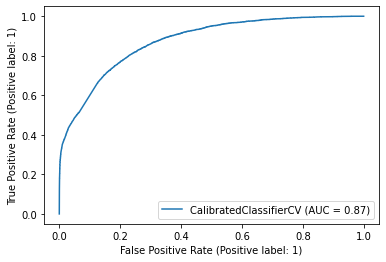

In [6]:
plot_roc_curve(best_model, x_valid_vect, y_valid.values.ravel())

What does high AUC mean? it means that our classifier could distinguish between classes

### Thresholding Visualization

In [7]:
thresholds = np.linspace(0,1,101)
proba = best_model.predict_proba(x_valid_vect)[:, 1]
proba = pd.DataFrame(proba)
proba.columns = ['probability']
score = []
for threshold_value in thresholds:
    proba['prediction'] = np.where( proba['probability'] > threshold_value, 1, 0)
    metric_score = f1_score(proba['prediction'], y_valid, average='macro')
    score.append(metric_score)
metric_score = pd.DataFrame([thresholds,score]).T
metric_score.columns = ['threshold','metric_score']

<AxesSubplot:xlabel='threshold'>

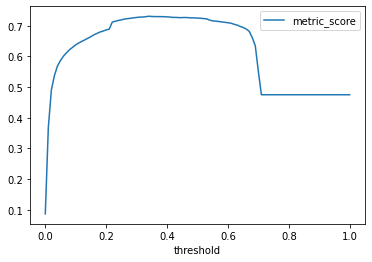

In [8]:
metric_score.plot(x='threshold',y='metric_score')

# Error Analysis

First, we would like to see the misclassified classes. We can do this using the confusion matrix

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

Text(0.5, 1.0, 'Confusion Matrix')

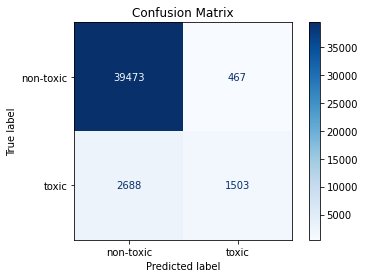

In [10]:
disp = ConfusionMatrixDisplay.from_estimator(
        best_model,
        x_valid_vect,
        y_valid,
        display_labels=['non-toxic','toxic'],
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title("Confusion Matrix")

Let's plot the probability distribution

In [11]:
y_valid

,toxic
133752,0
69259,0
9023,0
153272,0
2565,0
...,...
93876,0
106320,0
101828,0
170578,0


In [12]:
proba

,probability,prediction
0,0.006033,0
1,0.006474,0
2,0.012351,0
3,0.007597,0
4,0.106757,0
...,...,...
44126,0.007583,0
44127,0.017224,0
44128,0.020303,0
44129,0.401321,0


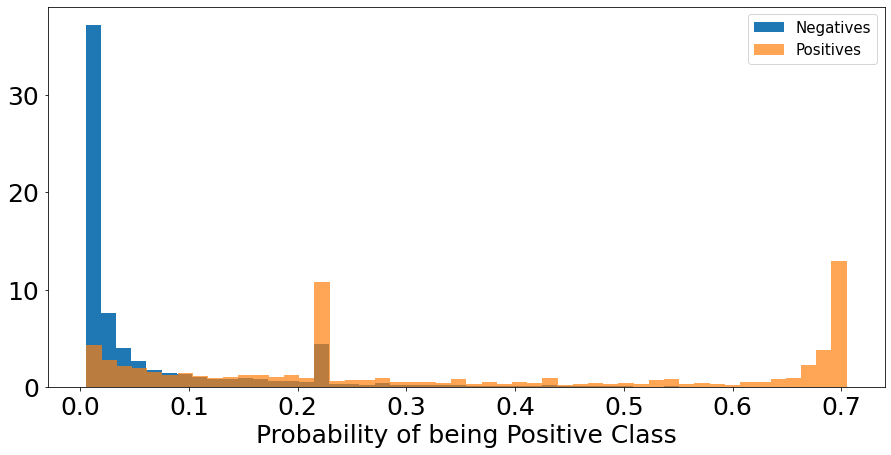

In [13]:
plt.figure(figsize=(15,7))
plt.hist(proba[y_valid.values.ravel()==0].probability, bins=50, label='Negatives', density=True)
plt.hist(proba[y_valid.values.ravel()==1].probability, bins=50, label='Positives', alpha=0.7, density=True)
plt.xlabel('Probability of being Positive Class', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

We have threshold 0.34. Now, we want to see the data

In [14]:
proba

,probability,prediction
0,0.006033,0
1,0.006474,0
2,0.012351,0
3,0.007597,0
4,0.106757,0
...,...,...
44126,0.007583,0
44127,0.017224,0
44128,0.020303,0
44129,0.401321,0


In [34]:
def split_df(y_valid_id, proba, x_valid_prep):
    y_val_id = y_valid_id.reset_index(drop=True)
    false_pos = y_val_id[(y_valid.values.ravel() == 1) & (proba.probability < 0.34)]
    false_neg = y_val_id[(y_valid.values.ravel() == 0) & (proba.probability > 0.34)]
    true_pos = y_val_id[(y_valid.values.ravel() == 1) & (proba.probability > 0.34)]
    true_neg = y_val_id[(y_valid.values.ravel() == 0) & (proba.probability < 0.34)]
    x_valid_fp = x_valid_prep[x_valid_prep.id.isin(false_pos.id)]
    x_valid_fn = x_valid_prep[x_valid_prep.id.isin(false_neg.id)]
    x_valid_tp = x_valid_prep[x_valid_prep.id.isin(true_pos.id)]
    x_valid_tn = x_valid_prep[x_valid_prep.id.isin(true_neg.id)]
    
    return x_valid_fp, x_valid_fn, x_valid_tp, x_valid_tn

Load preprocessed X_valid

In [43]:
x_valid_prep = joblib.load("../output/x_valid_preprocessed.pkl")
x_valid_raw = joblib.load("../output/x_valid.pkl")

In [36]:
x_fp, x_fn, x_tp, x_tn = split_df(y_valid_id, proba, x_valid_prep)

In [39]:
x_fp.head()

,id,comment_text
50886,88bcdab667d66d10,user abd muslim scum
139709,eee2f4f1ce628f01,suck dick wikiluser
193765,9067710fbce0d039,flames jackass
81009,d9a8ceaf9e429a01,attention faggot
37603,64d7880b6987daa6,accused sockpuppetry author makes sense know f...


In [40]:
x_fn.head()

,id,comment_text
52573,8d2e2ff120aae562,rough google tally aids denialist hits big tob...
173429,3bf4186e4baabb43,song fucking retarded lyrics time
173733,3d1e5f3d1e87a770,bate nate hussein curruntly years old born th ...
58049,9c1d31b1c5a34682,ip block problem like said people dont tools
18656,3174664a5932aca5,well know uncyclopedia made myke page believe ...


In [41]:
x_tp.head()

,id,comment_text
172076,3671a686ef987ca8,unblock cus fuck thats
127309,ac04b17583acfd3b,aww shut fuck little whiny bitch
196743,9c3e3e122339eeb1,english translation ngo yaw ngadlek ney yaw ng...
62908,a9208bd1beb28830,fuck youfuckingidiot
92313,f7f18a4655bc8e14,u guys bunch jerks fuck u hate


In [42]:
x_tn.head()

,id,comment_text
133752,ce62150bc62b0a0e,ac transit bus fight oops right article indeed...
69259,ba1391a10edc2d69,thank experimenting page canada wikipedia test...
9023,181e6bdeb5e8ab18,sienke could list eurovision song contest entr...
153272,a5a2f38d61c5a1f7,view classic pov rankings matter public record...
2565,06e2e079e0e1e9c6,lucy hannah fraud actual age lucy hannah compl...


### Maybe, the false positive caused by unseen words(?)

In [49]:
x_train_prep = joblib.load("../output/x_train_preprocessed.pkl")
y_train = joblib.load("../output/y_train.pkl")
train = pd.concat([x_train_prep, y_train], axis=1)
train = train.loc[:,~train.columns.duplicated()]

In [51]:
train[train.comment_text.str.contains('jackass')]

,id,comment_text,toxic
106733,3d303218bc9d56fa,illogical bans certainly sympathize plight mus...,0
93690,fbacf64b2f11bdb3,enforce arbitration decision blocked editing p...,0
62159,a71e414e75c5fd8c,washout facts prove washout fine ar declared u...,1
168427,27b254aa4b776ebf,yeah right let see said bright star catalog no...,0
68855,b912ae4fa4bf5164,hello mr fucking jackass cunt remember wasnt g...,1
...,...,...,...
47826,805225f6fdbffbfb,first place picture turkish bloody yataghan in...,1
46804,7d9a493d304f1b70,zionist jewbastard khazar turks love filibuste...,1
156981,e1d19b4f8a33137f,picture jackass known psychonaut go http www n...,0
17931,2f966c101629d1ac,move milwaukee fat jackass,1


Seems that our hypothesis is wrong. Any Idea? What analysis that could we do to understand our model?

What should we do next?
- Try to add and/or remove feature(s)
- Try other models: Neural Network(?)